In [ ]:
# code structure credit: (https://medium.com/@ankitvashisht12/classifying-dog-breed-using-pytorch-abc9f3c5128a)
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchsummary import summary
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


We use two datasets for our project:
1. <a href="https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset" name="id1">Stanford Dogs Dataset</a>
2. <a href="https://www.kaggle.com/datasets/eward96/dog-breed-images" name="id2">Dog Breed Images</a>

We will train the model on 7 dog breeds that appear in both
datasets: Bernese mountain dog, Border collie, Chihuahua, Golden retriever, Labrador, Pug, and Siberian husky. We combine the images from both datasets of these 7 dog breeds into one dataset for our project.

In [ ]:
data_path = "/content/drive/MyDrive/csc413_project/DataSet"
# unzip data
if os.path.exists(data_path) == False:
  !unzip /content/drive/MyDrive/csc413_project/DataSet.zip -d /content/drive/MyDrive/csc413_project/

## Data Setup

In [ ]:
# Load data
dataset = ImageFolder(f'{data_path}')

print(f"Dataset size: {len(dataset)}")
print(f"Dataset class: {dataset.classes}")

Dataset size: 1879
Dataset class: ['bernese_mountain_dog', 'border_collie', 'chihuahua', 'golden_retriever', 'labrador', 'pug', 'siberian_husky']


In [ ]:
random_seed = 45
torch.manual_seed(random_seed);

# Split the dataset
test_pct = 0.3
test_size = int(len(dataset) * test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.1
val_size = int(dataset_size * val_pct)
train_size = dataset_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

print(f"Training dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")
print(f"Testing dataset size: {len(test_ds)}")

Training dataset size: 1185
Validation dataset size: 131
Testing dataset size: 563


golden_retriever


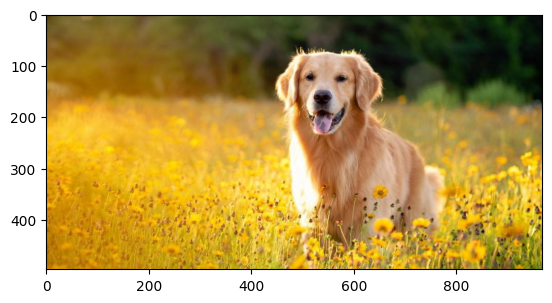

In [ ]:
img, label = train_ds[45]
print(dataset.classes[label])
plt.imshow(img)

### data augmentation

In [ ]:
class DogBreedDataset(Dataset):
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)
            return img, label

In [ ]:
# TODO: might need to change a little here
# for now, I set it s.t. we train on unaugmented images and
# do test and validation on augemented images. Not sure if this is a good choice

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
    transforms.ToTensor()
])


val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor()
])

train_dataset = DogBreedDataset(train_ds, train_transform)
val_dataset = DogBreedDataset(val_ds, val_transform)
test_dataset = DogBreedDataset(test_ds, test_transform)

golden_retriever


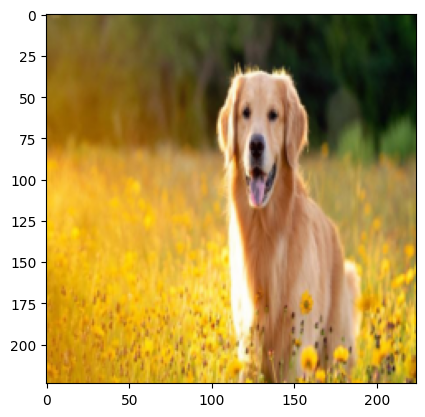

In [ ]:
img, label = train_dataset[45]
print(dataset.classes[label])
plt.imshow(img.permute(1,2,0))

In [ ]:
batch_size = 16

# Create DataLoaders
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)

### Moving data to GPU

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

In [ ]:
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val dataloader to gpu
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

cuda


# Network Architecture

### Depthwise Separable Convoltion Layer

In [ ]:
class DepthWiseConv(nn.Module):
  def __init__(self, in_channels, stride, kernel_size, padding):
    super(DepthWiseConv, self).__init__()
    self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels)
    self.norm = nn.BatchNorm2d(in_channels)
    self.activation = nn.ReLU(inplace=True)

  def forward(self, x):
    out = self.conv(x)
    out = self.activation(self.norm(out))
    return out

class PointWiseConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(PointWiseConv, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
    self.norm = nn.BatchNorm2d(out_channels)
    self.activation = nn.ReLU(inplace=True)

  def forward(self, x):
    out = self.conv(x)
    out = self.activation(self.norm(out))
    return out

class DepthSepConv(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=(3, 3), stride=1, padding=1, width_multiplier=1):
    super(DepthSepConv, self).__init__()
    self.alpha = width_multiplier
    in_channels = int(in_channels * width_multiplier)
    out_channels = int(out_channels * width_multiplier)
    self.depthwise = DepthWiseConv(in_channels, kernel_size=kernel_size, stride=stride, padding=padding)
    self.pointwise = PointWiseConv(in_channels, out_channels)

  def forward(self, x):
    # todo, thin input x to be alpha * x
    out = self.depthwise(x)
    out = self.pointwise(out)
    return out

### Deformable Convolution Layer

In [ ]:
class DeformConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(DeformConv, self).__init__()
        # (1) self.p_conv: this is the convolution that get's the offset
        # (2) self.conv1: this is the final convolution
        self.N = kernel_size * kernel_size
        self.k = kernel_size

        self.p_conv = nn.Conv2d(in_channels, 2*self.N, (3, 3), stride=1, padding=1)
        self.conv1 = nn.Conv2d(in_channels, out_channels, (3, 3), stride=3)

    def forward(self, inputs):
        """Forward pass of the deformable convolution layer.

        Arguments:
            inputs: (batch_size x in_channels x height x width) # Not sure

        Returns:

        """
        height = inputs.shape[2]
        width = inputs.shape[3]
        num_channels = inputs.shape[1]
        batch_size = inputs.shape[0]

        # 1. p_conv and get offset
        offset = self.p_conv(inputs)  # size: (batch_size x 2N x height x width) ## since stride is 1

        # 2. calculate p and reshape it
        ## p0
        x = torch.arange(0, height).view(height, 1).expand(height, width).to(device)
        y = torch.arange(0, width).view(1, width).expand(height, width).to(device)
        p0 = torch.cat((x.view(1, height, width), y.view(1, height, width)), 0)  # size: (2 x height x width)
        p0 = p0.view(1, 2, height, width).expand(self.N, p0.shape[0], p0.shape[1], p0.shape[2]).reshape((2*self.N, height, width))  # size: (2N x height x width)

        ## pn
        r = (torch.arange(0, 3)-1).view(3, 1).expand(3, 3).to(device)
        z = torch.cat((r.view(1, 3, 3), r.transpose(0, 1).view(1, 3, 3)), 0) # size: (2 x 3 x 3)
        pn = z.transpose(0, 2).transpose(0, 1).flatten()
        pn = pn.view(2*self.N, 1).expand(2*self.N, height).view(2*self.N, height, 1).expand(2*self.N, height, width)  # size: (2N x height x width)
        to_device(pn, device)

        p = p0 + pn + offset  # size: (batch_size x 2N x height x width)
        p = p.transpose(1, -1).transpose(1, 2)  # reshape size: (batch_size x height x width x 2N)

        # 3. bilinear interpolation
        x_ind = torch.clamp(p[..., ::2], min=0, max=height-1)  # size: (batch_size x height x width x N)
        y_ind = torch.clamp(p[..., 1::2], min=0, max=width-1)

        qx_top = torch.floor(x_ind).type(torch.LongTensor).to(device)  # size: (batch_size x height x width x N)
        qx_bottom = torch.ceil(x_ind).type(torch.LongTensor).to(device)
        qy_left = torch.floor(y_ind).type(torch.LongTensor).to(device)
        qy_right = torch.ceil(y_ind).type(torch.LongTensor).to(device)

        valid_num = x_ind.shape[0]
        ## performing interpolation
        g1 = (1-torch.abs(qx_top - x_ind)) * (1-torch.abs(qy_left - y_ind))  # size: (batch_size x height x width x N)
        g2 = (1-torch.abs(qx_top - x_ind)) * (1-torch.abs(qy_right - y_ind))
        g3 = (1-torch.abs(qx_bottom - x_ind)) * (1-torch.abs(qy_left - y_ind))
        g4 = (1-torch.abs(qx_bottom - x_ind)) * (1-torch.abs(qy_right - y_ind))

        g1 = g1.view(batch_size, 1, height, width, self.N)
        g2 = g2.view(batch_size, 1, height, width, self.N)
        g3 = g3.view(batch_size, 1, height, width, self.N)
        g4 = g4.view(batch_size, 1, height, width, self.N)

        reshaped_inputs = inputs.view(batch_size, num_channels, height*width)

        q1_ind = (qx_top * width + qy_left).unsqueeze(1).expand(batch_size, num_channels, height, width, self.N).contiguous().view(batch_size, num_channels, -1)
        q1 = reshaped_inputs.gather(dim=-1, index=q1_ind).view(batch_size, num_channels, height, width, self.N)

        q2_ind = (qx_top * width + qy_right).unsqueeze(1).expand(batch_size, num_channels, height, width, self.N).contiguous().view(batch_size, num_channels, -1)
        q2 = reshaped_inputs.gather(dim=-1, index=q2_ind).view(batch_size, num_channels, height, width, self.N)

        q3_ind = (qx_bottom * width + qy_left).unsqueeze(1).expand(batch_size, num_channels, height, width, self.N).contiguous().view(batch_size, num_channels, -1)
        q3 = reshaped_inputs.gather(dim=-1, index=q3_ind).view(batch_size, num_channels, height, width, self.N)

        q4_ind = (qx_bottom * width + qy_right).unsqueeze(1).expand(batch_size, num_channels, height, width, self.N).contiguous().view(batch_size, num_channels, -1)
        q4 = reshaped_inputs.gather(dim=-1, index=q4_ind).view(batch_size, num_channels, height, width, self.N)

        ## elementwise multiplication
        x_offset = g1*q1 + g2*q2 + g3*q3 + g4*q4

        # 4. reshape
        x_offset = x_offset.reshape(batch_size, num_channels,
                                    height, width, self.k, self.k).transpose(3, 4).reshape(batch_size, num_channels,
                                                                                           height*self.k, width*self.k)

        # 5. final convolution
        x = self.conv1(x_offset) # size: (batch_size x 2N x height x width)
        return x


In [ ]:
# ### test
# a = torch.zeros(1, 1, 2, 3, 9)
# a[0][0][0][0][7] = 1
# a[0][0][0][1][7] = 1
# print(a)
# a = a.reshape(1, 1, 2, 3, 3, 3)
# a

### Build-up Network

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    # training step
    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        return loss

    # validation step
    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        acc = accuracy(out, targets)
        return {'val_acc':acc.detach(), 'val_loss':loss.detach()}

    # validation epoch end
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}

    # print result end epoch
    def epoch_end(self, epoch, result):
        print("Epoch [{}] : train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"], result["train_acc"], result["val_loss"], result["val_acc"]))

#### Base CNN

In [ ]:
# Base CNN
class DogBreedClassificationCNN(ImageClassificationBase):
    def __init__(self, in_channels=3, num_class=7):
        super().__init__()
        """
        input size: 224 * 224 * 3

        output size before average pool: 14 * 14 * 256
        """
        # first convolution, same for all cases
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        ) # 112 * 112 * 32

        self.network, self.final_channels = self.constuct_network()

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=1)

        self.fc = nn.Sequential(
            nn.Linear(self.final_channels, num_class),
            nn.LogSoftmax(dim = 1),
        )

    # repeating middle conv layers
    def constuct_network(self, num_layers=6, in_channels=32):
      layers = OrderedDict()
      # using stride=2 for even layers to perform as subsampling
      # increase features size by 2 for every 2 convolutions
      for i in range(num_layers):
        if (i + 1) % 2 == 0:
          stride = (2, 2)
          out_channels = in_channels*2
        else:
          stride = (1, 1)
          out_channels = in_channels

        layers[f"layer{i}"] = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), stride=stride, padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        in_channels = out_channels

      return nn.Sequential(layers), in_channels

    def forward(self, xb):
      x = self.conv1(xb)
      x1 = self.network(x)
      x2 = self.avgpool(x1).squeeze((2, 3))
      return self.fc(x2)

In [ ]:
# moving model to gpu
base_model = DogBreedClassificationCNN()
to_device(base_model, device)

summary(base_model, (3, 224, 224), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           9,248
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              ReLU-6         [-1, 32, 112, 112]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
       BatchNorm2d-8           [-1, 64, 56, 56]             128
              ReLU-9           [-1, 64, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]          36,928
      BatchNorm2d-11           [-1, 64, 56, 56]             128
             ReLU-12           [-1, 64, 56, 56]               0
           Conv2d-13          [-1, 128, 28, 28]          73,856
      BatchNorm2d-14          [-1, 128,

#### Deformable CNN

In [ ]:
# Deformable CNN
class DogBreedClassificationDeformableCNN(ImageClassificationBase):
    def __init__(self, in_channels=3, num_class=7):
        super().__init__()
        """
        input size: 224 * 224 * 3

        output size before average pool: 14 * 14 * 256
        """
        # first convolution, same for all cases
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        ) # 112 * 112 * 32

        self.network, self.final_channels = self.constuct_network()

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=1)

        self.fc = nn.Sequential(
            nn.Linear(self.final_channels, num_class),
            nn.LogSoftmax(dim = 1),
        )

    # repeating middle conv layers
    def constuct_network(self, num_layers=6, in_channels=32):
      layers = OrderedDict()
      # using stride=2 for even layers to perform as subsampling
      # increase features size by 2 for every 2 convolutions
      for i in range(num_layers):
        if (i + 1) % 2 == 0:
          stride = (2, 2)
          out_channels = in_channels*2
          conv = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), stride=stride, padding=(1, 1))
        else:
          stride = (1, 1)
          out_channels = in_channels
          conv = DeformConv(in_channels, out_channels, kernel_size=3)

        layers[f"layer{i}"] = nn.Sequential(
            conv,
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        in_channels = out_channels

      return nn.Sequential(layers), in_channels

    def forward(self, xb):
      x = self.conv1(xb)
      x1 = self.network(x)
      x2 = self.avgpool(x1).squeeze((2, 3))
      return self.fc(x2)

In [ ]:
# moving model to gpu
deform_model = DogBreedClassificationDeformableCNN()
to_device(deform_model, device)
summary(deform_model, (3, 224, 224), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 18, 112, 112]           5,202
            Conv2d-5         [-1, 32, 112, 112]           9,248
        DeformConv-6         [-1, 32, 112, 112]               0
       BatchNorm2d-7         [-1, 32, 112, 112]              64
              ReLU-8         [-1, 32, 112, 112]               0
            Conv2d-9           [-1, 64, 56, 56]          18,496
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 18, 56, 56]          10,386
           Conv2d-13           [-1, 64, 56, 56]          36,928
       DeformConv-14           [-1, 64,

#### Depthwise Separable CNN

In [ ]:
# Depthwise Separable CNN
class DogBreedClassificationDSC(ImageClassificationBase):
    def __init__(self, in_channels=3, num_class=7):
        super().__init__()
        """
        input size: 224 * 224 * 3

        output size before average pool: 14 * 14 * 256
        """
        # first convolution, same for all cases
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        ) # 112 * 112 * 32

        self.network, self.final_channels = self.constuct_network()

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=1)

        self.fc = nn.Sequential(
            nn.Linear(self.final_channels, num_class),
            nn.LogSoftmax(dim = 1),
        )

    # repeating middle conv layers
    def constuct_network(self, num_layers=6, in_channels=32):
      layers = OrderedDict()
      # using stride=2 for even layers to perform as subsampling
      # increase features size by 2 for every 2 convolutions
      for i in range(num_layers):
        if (i + 1) % 2 == 0:
          stride = (2, 2)
          out_channels = in_channels*2
        else:
          stride = (1, 1)
          out_channels = in_channels

        layers[f"layer{i}"] = DepthSepConv(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        # nn.Sequential(
            # DepthSepConv(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
            # nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), stride=stride, padding=(1, 1)),
            # nn.BatchNorm2d(out_channels),
            # nn.ReLU(inplace=True)
        # )

        in_channels = out_channels

      return nn.Sequential(layers), in_channels

    def forward(self, xb):
      x = self.conv1(xb)
      x1 = self.network(x)
      x2 = self.avgpool(x1).squeeze((2, 3))
      return self.fc(x2)

In [ ]:
# model summary
dsc_model = DogBreedClassificationDSC()
to_device(dsc_model, device)
summary(dsc_model, (3, 224, 224), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             320
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              ReLU-6         [-1, 32, 112, 112]               0
     DepthWiseConv-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 32, 112, 112]           1,056
       BatchNorm2d-9         [-1, 32, 112, 112]              64
             ReLU-10         [-1, 32, 112, 112]               0
    PointWiseConv-11         [-1, 32, 112, 112]               0
     DepthSepConv-12         [-1, 32, 112, 112]               0
           Conv2d-13           [-1, 32, 56, 56]             320
      BatchNorm2d-14           [-1, 32,

# Training:

### Train setup

In [ ]:
# the training part might need modification as well (now it's just a direct copy of 420a2)
from tqdm.notebook import tqdm
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func = torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # set up one cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):

        # Training phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)

            # calculates gradients
            loss.backward()

            # check gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            # perform gradient descent and modifies the weights
            optimizer.step()

            # reset the gradients
            optimizer.zero_grad()

            # record and update lr
            lrs.append(get_lr(optimizer))

            # modifies the lr value
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs

        # additional info
        result1 = evaluate(model, train_loader)
        result['train_acc'] = result1['val_acc']

        model.epoch_end(epoch, result)
        history.append(result)

    return history



@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [ ]:
base_model1 = DogBreedClassificationCNN()
to_device(base_model1, device)

# set hyperparams
num_epochs = 10
opt_func = torch.optim.SGD

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

base_history = fit_one_cycle(num_epochs, max_lr, base_model1, train_dl, val_dl, weight_decay, grad_clip, opt_func)

num_epochs = 7
max_lr = 0.001
base_history += fit_one_cycle(num_epochs, max_lr, base_model1, train_dl, val_dl, weight_decay, grad_clip, opt_func)

num_epochs = 3
max_lr = 0.0001
base_history += fit_one_cycle(num_epochs, max_lr, base_model1, train_dl, val_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [0] : train_loss: 1.9122, train_acc: 0.2608, val_loss: 1.8198, val_acc: 0.2313


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [1] : train_loss: 1.8381, train_acc: 0.2600, val_loss: 1.9255, val_acc: 0.2438


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2] : train_loss: 1.7942, train_acc: 0.2192, val_loss: 1.9642, val_acc: 0.1312


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [3] : train_loss: 1.7675, train_acc: 0.3000, val_loss: 2.2518, val_acc: 0.1875


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [4] : train_loss: 1.6969, train_acc: 0.2800, val_loss: 1.9806, val_acc: 0.2729


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [5] : train_loss: 1.6590, train_acc: 0.3050, val_loss: 2.0560, val_acc: 0.2854


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [6] : train_loss: 1.6222, train_acc: 0.3425, val_loss: 1.7843, val_acc: 0.3042


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [7] : train_loss: 1.5654, train_acc: 0.4350, val_loss: 1.6223, val_acc: 0.4167


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [8] : train_loss: 1.4960, train_acc: 0.4883, val_loss: 1.5082, val_acc: 0.4292


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [9] : train_loss: 1.4608, train_acc: 0.4692, val_loss: 1.4697, val_acc: 0.4229


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [0] : train_loss: 1.4286, train_acc: 0.4825, val_loss: 1.6229, val_acc: 0.4167


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [1] : train_loss: 1.4321, train_acc: 0.4758, val_loss: 1.5889, val_acc: 0.4229


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2] : train_loss: 1.4317, train_acc: 0.4867, val_loss: 1.5418, val_acc: 0.4542


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [3] : train_loss: 1.4225, train_acc: 0.4967, val_loss: 1.5506, val_acc: 0.4667


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [4] : train_loss: 1.4081, train_acc: 0.5208, val_loss: 1.5119, val_acc: 0.4729


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [5] : train_loss: 1.4076, train_acc: 0.4992, val_loss: 1.5693, val_acc: 0.4292


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [6] : train_loss: 1.3788, train_acc: 0.5100, val_loss: 1.5236, val_acc: 0.4042


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [0] : train_loss: 1.3604, train_acc: 0.5100, val_loss: 1.5239, val_acc: 0.4167


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [1] : train_loss: 1.3772, train_acc: 0.5192, val_loss: 1.5975, val_acc: 0.4042


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2] : train_loss: 1.3761, train_acc: 0.5067, val_loss: 1.5407, val_acc: 0.4292


### Train Deformable CNN

In [ ]:
deform_model = DogBreedClassificationDeformableCNN()
to_device(deform_model, device)

# set hyperparams
num_epochs = 10
opt_func = torch.optim.SGD

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

history = fit_one_cycle(num_epochs, max_lr, deform_model, train_dl, val_dl, weight_decay, grad_clip, opt_func)

num_epochs = 7
max_lr = 0.001
history += fit_one_cycle(num_epochs, max_lr, deform_model, train_dl, val_dl, weight_decay, grad_clip, opt_func)

num_epochs = 3
max_lr = 0.0001
history += fit_one_cycle(num_epochs, max_lr, deform_model, train_dl, val_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [0] : train_loss: 1.9014, val_loss: 1.9031, val_acc: 0.2125


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [1] : train_loss: 1.8082, val_loss: 2.1202, val_acc: 0.2167


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2] : train_loss: 1.7944, val_loss: 1.7967, val_acc: 0.2979


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [3] : train_loss: 1.7708, val_loss: 1.8146, val_acc: 0.2792


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [4] : train_loss: 1.7382, val_loss: 2.1224, val_acc: 0.1625


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [5] : train_loss: 1.7255, val_loss: 1.6984, val_acc: 0.3896


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [6] : train_loss: 1.6769, val_loss: 1.9434, val_acc: 0.3104


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [7] : train_loss: 1.6591, val_loss: 1.7035, val_acc: 0.3896


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [8] : train_loss: 1.6062, val_loss: 1.7517, val_acc: 0.3354


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [9] : train_loss: 1.5477, val_loss: 1.7538, val_acc: 0.3542


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [0] : train_loss: 1.5557, val_loss: 1.8557, val_acc: 0.2979


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [1] : train_loss: 1.5801, val_loss: 1.7256, val_acc: 0.3354


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2] : train_loss: 1.5546, val_loss: 1.7792, val_acc: 0.3104


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [3] : train_loss: 1.5701, val_loss: 1.6721, val_acc: 0.4021


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [4] : train_loss: 1.5345, val_loss: 1.8157, val_acc: 0.3229


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [5] : train_loss: 1.5388, val_loss: 1.8804, val_acc: 0.3229


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [6] : train_loss: 1.5214, val_loss: 1.7211, val_acc: 0.3104


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [0] : train_loss: 1.5124, val_loss: 2.0047, val_acc: 0.2854


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [1] : train_loss: 1.5315, val_loss: 1.7027, val_acc: 0.3604


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2] : train_loss: 1.5516, val_loss: 1.6534, val_acc: 0.3229


### Train base CNN

In [ ]:
base_model = DogBreedClassificationCNN()
to_device(base_model, device)

# set hyperparams
num_epochs = 10
opt_func = torch.optim.SGD

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

base_history = fit_one_cycle(num_epochs, max_lr, base_model, train_dl, val_dl, weight_decay, grad_clip, opt_func)

num_epochs = 7
max_lr = 0.001
base_history += fit_one_cycle(num_epochs, max_lr, base_model, train_dl, val_dl, weight_decay, grad_clip, opt_func)

num_epochs = 3
max_lr = 0.0001
base_history += fit_one_cycle(num_epochs, max_lr, base_model, train_dl, val_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/38 [00:00<?, ?it/s]

In [ ]:
### test basic cnn convergence

base2_model = DogBreedClassificationCNN()
to_device(base2_model, device)

# set hyperparams
num_epochs = 50
opt_func = torch.optim.SGD

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

base_history = fit_one_cycle(num_epochs, max_lr, base_model, train_dl, val_dl, weight_decay, grad_clip, opt_func)

num_epochs = 7
max_lr = 0.001
base_history += fit_one_cycle(num_epochs, max_lr, base_model, train_dl, val_dl, weight_decay, grad_clip, opt_func)

num_epochs = 3
max_lr = 0.0001
base_history += fit_one_cycle(num_epochs, max_lr, base_model, train_dl, val_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [0] : train_loss: 1.8879, train_acc: 0.2933, val_loss: 1.7777, val_acc: 0.3583


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [1] : train_loss: 1.7811, train_acc: 0.3133, val_loss: 1.7286, val_acc: 0.3229


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2] : train_loss: 1.7423, train_acc: 0.2983, val_loss: 1.7259, val_acc: 0.3042


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [3] : train_loss: 1.7459, train_acc: 0.2967, val_loss: 1.9852, val_acc: 0.2438


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [4] : train_loss: 1.7593, train_acc: 0.3267, val_loss: 1.8709, val_acc: 0.2979


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [5] : train_loss: 1.6933, train_acc: 0.2583, val_loss: 2.0558, val_acc: 0.1750


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [6] : train_loss: 1.6886, train_acc: 0.3325, val_loss: 1.7504, val_acc: 0.3292


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [7] : train_loss: 1.6600, train_acc: 0.3408, val_loss: 1.6368, val_acc: 0.2979


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [8] : train_loss: 1.6369, train_acc: 0.2508, val_loss: 2.1135, val_acc: 0.2792


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [9] : train_loss: 1.6396, train_acc: 0.2742, val_loss: 2.1578, val_acc: 0.2562


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [10] : train_loss: 1.5984, train_acc: 0.2325, val_loss: 3.6491, val_acc: 0.2729


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [11] : train_loss: 1.5616, train_acc: 0.3283, val_loss: 1.9767, val_acc: 0.2667


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [12] : train_loss: 1.5327, train_acc: 0.3383, val_loss: 1.6321, val_acc: 0.3104


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [13] : train_loss: 1.5408, train_acc: 0.2292, val_loss: 4.4960, val_acc: 0.1688


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [14] : train_loss: 1.4964, train_acc: 0.4533, val_loss: 1.6033, val_acc: 0.4708


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [15] : train_loss: 1.4396, train_acc: 0.2483, val_loss: 3.3235, val_acc: 0.2854


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [16] : train_loss: 1.4722, train_acc: 0.2467, val_loss: 3.1030, val_acc: 0.2000


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [17] : train_loss: 1.4003, train_acc: 0.4300, val_loss: 1.6140, val_acc: 0.4771


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [18] : train_loss: 1.3392, train_acc: 0.3933, val_loss: 2.1660, val_acc: 0.2917


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [19] : train_loss: 1.3786, train_acc: 0.4092, val_loss: 1.7219, val_acc: 0.3979


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [20] : train_loss: 1.3054, train_acc: 0.4975, val_loss: 1.5655, val_acc: 0.3542


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [21] : train_loss: 1.2809, train_acc: 0.4992, val_loss: 1.4532, val_acc: 0.5146


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [22] : train_loss: 1.3041, train_acc: 0.5250, val_loss: 1.5505, val_acc: 0.4167


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [23] : train_loss: 1.2498, train_acc: 0.3300, val_loss: 2.3204, val_acc: 0.3167


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [24] : train_loss: 1.2504, train_acc: 0.5675, val_loss: 1.3446, val_acc: 0.5583


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [25] : train_loss: 1.1923, train_acc: 0.5808, val_loss: 1.3849, val_acc: 0.4187


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [26] : train_loss: 1.1707, train_acc: 0.4117, val_loss: 2.4940, val_acc: 0.3854


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [27] : train_loss: 1.2160, train_acc: 0.4808, val_loss: 1.8538, val_acc: 0.3167


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [28] : train_loss: 1.1911, train_acc: 0.4358, val_loss: 1.8751, val_acc: 0.3354


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [29] : train_loss: 1.1543, train_acc: 0.4925, val_loss: 1.4604, val_acc: 0.4833


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [30] : train_loss: 1.0959, train_acc: 0.4517, val_loss: 1.8093, val_acc: 0.3479


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [31] : train_loss: 1.0654, train_acc: 0.5883, val_loss: 1.1807, val_acc: 0.5708


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [32] : train_loss: 1.0550, train_acc: 0.6308, val_loss: 1.3055, val_acc: 0.5396


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [33] : train_loss: 1.0407, train_acc: 0.5508, val_loss: 1.3956, val_acc: 0.4646


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [34] : train_loss: 0.9729, train_acc: 0.5208, val_loss: 1.7609, val_acc: 0.5271


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [35] : train_loss: 0.9903, train_acc: 0.5892, val_loss: 1.5079, val_acc: 0.5521


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [36] : train_loss: 0.9570, train_acc: 0.6367, val_loss: 1.2841, val_acc: 0.5333


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [37] : train_loss: 0.9375, train_acc: 0.7100, val_loss: 1.5120, val_acc: 0.4417


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [38] : train_loss: 0.8884, train_acc: 0.7367, val_loss: 1.2714, val_acc: 0.5521


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [39] : train_loss: 0.8424, train_acc: 0.7692, val_loss: 1.2754, val_acc: 0.5083


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [40] : train_loss: 0.8725, train_acc: 0.7758, val_loss: 1.2526, val_acc: 0.5208


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [41] : train_loss: 0.8121, train_acc: 0.7658, val_loss: 1.1990, val_acc: 0.6208


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [42] : train_loss: 0.7355, train_acc: 0.7692, val_loss: 1.4206, val_acc: 0.5396


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [43] : train_loss: 0.7591, train_acc: 0.8025, val_loss: 1.4311, val_acc: 0.5333


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [44] : train_loss: 0.6849, train_acc: 0.8225, val_loss: 1.5012, val_acc: 0.5208


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [45] : train_loss: 0.6964, train_acc: 0.8417, val_loss: 1.3188, val_acc: 0.5583


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [46] : train_loss: 0.6566, train_acc: 0.8492, val_loss: 1.2350, val_acc: 0.5646


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [47] : train_loss: 0.6278, train_acc: 0.8425, val_loss: 1.2021, val_acc: 0.5708


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [48] : train_loss: 0.5862, train_acc: 0.8617, val_loss: 1.3147, val_acc: 0.6021


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [49] : train_loss: 0.6289, train_acc: 0.8633, val_loss: 1.2514, val_acc: 0.5708


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [0] : train_loss: 0.6149, train_acc: 0.8508, val_loss: 1.0746, val_acc: 0.5833


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [1] : train_loss: 0.6388, train_acc: 0.8600, val_loss: 1.2742, val_acc: 0.5042


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2] : train_loss: 0.6314, train_acc: 0.8158, val_loss: 1.5546, val_acc: 0.5333


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [3] : train_loss: 0.6417, train_acc: 0.8483, val_loss: 1.2545, val_acc: 0.5958


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [4] : train_loss: 0.5883, train_acc: 0.8600, val_loss: 1.1426, val_acc: 0.6146


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [5] : train_loss: 0.6145, train_acc: 0.8683, val_loss: 1.0282, val_acc: 0.6333


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [6] : train_loss: 0.5973, train_acc: 0.8767, val_loss: 1.2078, val_acc: 0.6208


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [0] : train_loss: 0.5592, train_acc: 0.8742, val_loss: 1.0609, val_acc: 0.6271


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [1] : train_loss: 0.5601, train_acc: 0.8808, val_loss: 1.2227, val_acc: 0.6208


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2] : train_loss: 0.5498, train_acc: 0.8575, val_loss: 1.1075, val_acc: 0.6083


### Train Depthwise Separable CNN

In [ ]:
### Train Depthwisee Separablee CNN
dsc_model = DogBreedClassificationDSC()
to_device(dsc_model, device)

# set hyperparams
num_epochs = 50
opt_func = torch.optim.SGD

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

dsc_history = fit_one_cycle(num_epochs, max_lr, dsc_model, train_dl, val_dl, weight_decay, grad_clip, opt_func)

num_epochs = 7
max_lr = 0.001
dsc_history += fit_one_cycle(num_epochs, max_lr, dsc_model, train_dl, val_dl, weight_decay, grad_clip, opt_func)

num_epochs = 3
max_lr = 0.0001
dsc_history += fit_one_cycle(num_epochs, max_lr, dsc_model, train_dl, val_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [0] : train_loss: 1.9452, train_acc: 0.2100, val_loss: 1.9143, val_acc: 0.2229


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [1] : train_loss: 1.9308, train_acc: 0.2050, val_loss: 1.9053, val_acc: 0.2354


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2] : train_loss: 1.9144, train_acc: 0.1883, val_loss: 1.8780, val_acc: 0.2104


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [3] : train_loss: 1.8737, train_acc: 0.2775, val_loss: 1.7877, val_acc: 0.3521


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [4] : train_loss: 1.8247, train_acc: 0.3075, val_loss: 1.7844, val_acc: 0.3104


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [5] : train_loss: 1.7839, train_acc: 0.3042, val_loss: 1.6881, val_acc: 0.3042


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [6] : train_loss: 1.7608, train_acc: 0.2542, val_loss: 1.8904, val_acc: 0.2292


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [7] : train_loss: 1.7529, train_acc: 0.3175, val_loss: 1.7746, val_acc: 0.3646


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [8] : train_loss: 1.7535, train_acc: 0.3125, val_loss: 2.0292, val_acc: 0.2729


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [9] : train_loss: 1.7148, train_acc: 0.3467, val_loss: 1.8415, val_acc: 0.2688


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [10] : train_loss: 1.6578, train_acc: 0.3225, val_loss: 1.7025, val_acc: 0.3354


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [11] : train_loss: 1.6525, train_acc: 0.3808, val_loss: 1.8518, val_acc: 0.3104


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [12] : train_loss: 1.6562, train_acc: 0.3300, val_loss: 1.6859, val_acc: 0.3167


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [13] : train_loss: 1.5914, train_acc: 0.3733, val_loss: 2.2160, val_acc: 0.2854


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [14] : train_loss: 1.5657, train_acc: 0.4225, val_loss: 1.8087, val_acc: 0.3896


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [15] : train_loss: 1.5140, train_acc: 0.4092, val_loss: 1.8641, val_acc: 0.3354


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [16] : train_loss: 1.4828, train_acc: 0.4817, val_loss: 2.0621, val_acc: 0.3292


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [17] : train_loss: 1.3948, train_acc: 0.4100, val_loss: 1.9877, val_acc: 0.3292


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [18] : train_loss: 1.3778, train_acc: 0.5242, val_loss: 1.5399, val_acc: 0.4896


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [19] : train_loss: 1.3247, train_acc: 0.4825, val_loss: 1.9318, val_acc: 0.3833


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [20] : train_loss: 1.2714, train_acc: 0.5575, val_loss: 1.5555, val_acc: 0.4458


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [21] : train_loss: 1.2367, train_acc: 0.4683, val_loss: 1.4965, val_acc: 0.5375


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [22] : train_loss: 1.2159, train_acc: 0.5133, val_loss: 1.6215, val_acc: 0.4458


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [23] : train_loss: 1.1788, train_acc: 0.4867, val_loss: 1.8304, val_acc: 0.4333


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [24] : train_loss: 1.1570, train_acc: 0.3933, val_loss: 2.6013, val_acc: 0.2604


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [25] : train_loss: 1.1188, train_acc: 0.6233, val_loss: 1.5991, val_acc: 0.4771


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [26] : train_loss: 1.0850, train_acc: 0.5450, val_loss: 1.7070, val_acc: 0.4521


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [27] : train_loss: 1.0982, train_acc: 0.5875, val_loss: 1.6381, val_acc: 0.5083


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [28] : train_loss: 1.0452, train_acc: 0.6400, val_loss: 1.7592, val_acc: 0.4646


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [29] : train_loss: 1.0410, train_acc: 0.6275, val_loss: 1.8279, val_acc: 0.4521


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [30] : train_loss: 1.0018, train_acc: 0.5083, val_loss: 2.4476, val_acc: 0.3604


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [31] : train_loss: 0.9981, train_acc: 0.7167, val_loss: 1.4341, val_acc: 0.5458


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [32] : train_loss: 0.9731, train_acc: 0.6717, val_loss: 1.2247, val_acc: 0.5458


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [33] : train_loss: 0.9304, train_acc: 0.6750, val_loss: 1.5061, val_acc: 0.5396


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [34] : train_loss: 0.8875, train_acc: 0.6975, val_loss: 1.4620, val_acc: 0.4896


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [35] : train_loss: 0.8780, train_acc: 0.6458, val_loss: 1.5552, val_acc: 0.4479


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [36] : train_loss: 0.8781, train_acc: 0.7325, val_loss: 1.3791, val_acc: 0.4479


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [37] : train_loss: 0.8808, train_acc: 0.7475, val_loss: 1.5710, val_acc: 0.4646


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [38] : train_loss: 0.8155, train_acc: 0.7608, val_loss: 1.4927, val_acc: 0.5021


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [39] : train_loss: 0.7875, train_acc: 0.7592, val_loss: 1.4962, val_acc: 0.5333


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [40] : train_loss: 0.7661, train_acc: 0.7842, val_loss: 1.2020, val_acc: 0.5833


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [41] : train_loss: 0.6979, train_acc: 0.8217, val_loss: 1.4949, val_acc: 0.5458


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [42] : train_loss: 0.6924, train_acc: 0.8283, val_loss: 1.4931, val_acc: 0.5583


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [43] : train_loss: 0.6763, train_acc: 0.8267, val_loss: 1.4788, val_acc: 0.5896


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [44] : train_loss: 0.6465, train_acc: 0.8317, val_loss: 1.2081, val_acc: 0.5396


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [45] : train_loss: 0.6515, train_acc: 0.8575, val_loss: 1.3714, val_acc: 0.5833


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [46] : train_loss: 0.6270, train_acc: 0.8492, val_loss: 1.2256, val_acc: 0.5396


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [47] : train_loss: 0.6448, train_acc: 0.8300, val_loss: 1.3106, val_acc: 0.5708


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [48] : train_loss: 0.6428, train_acc: 0.8408, val_loss: 1.2823, val_acc: 0.5458


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [49] : train_loss: 0.6051, train_acc: 0.8317, val_loss: 1.4020, val_acc: 0.5458


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [0] : train_loss: 0.6263, train_acc: 0.8358, val_loss: 1.4427, val_acc: 0.5333


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [1] : train_loss: 0.6280, train_acc: 0.8400, val_loss: 1.3858, val_acc: 0.5896


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2] : train_loss: 0.6354, train_acc: 0.8467, val_loss: 1.2913, val_acc: 0.5521


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [3] : train_loss: 0.6009, train_acc: 0.8475, val_loss: 1.3517, val_acc: 0.5833


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [4] : train_loss: 0.5938, train_acc: 0.8683, val_loss: 1.3050, val_acc: 0.5958


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [5] : train_loss: 0.5950, train_acc: 0.8700, val_loss: 1.2580, val_acc: 0.5167


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [6] : train_loss: 0.6036, train_acc: 0.8692, val_loss: 1.3231, val_acc: 0.5396


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [0] : train_loss: 0.5946, train_acc: 0.8575, val_loss: 1.2699, val_acc: 0.6021


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [1] : train_loss: 0.5790, train_acc: 0.8567, val_loss: 1.2017, val_acc: 0.5896


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2] : train_loss: 0.5744, train_acc: 0.8508, val_loss: 1.1783, val_acc: 0.5708


# Plot:

In [ ]:
history = dsc_history
train_acc = []
val_acc = []
time = list(range(len(history)))
for h in history:
    train_acc.append(h['train_acc'])
    val_acc.append(h['val_acc'])

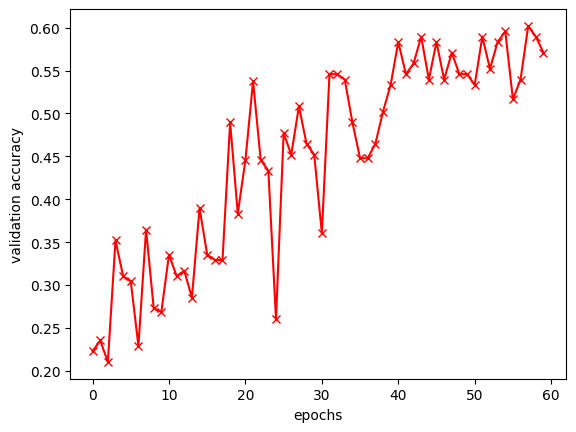

In [ ]:
plt.plot(time, val_acc, c='red', label='accuracy', marker='x')
plt.xlabel('epochs')
plt.ylabel('validation accuracy')
plt.show()

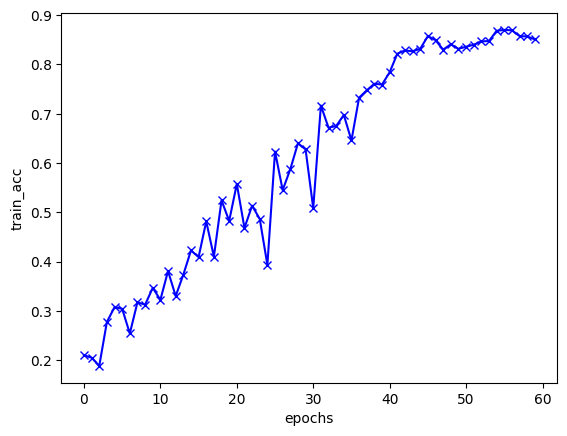

In [ ]:
plt.plot(time, train_acc, c='blue', label='train_acc', marker='x')
plt.xlabel('epochs')
plt.ylabel('train_acc')
plt.show()

# Test

In [ ]:
result = evaluate(dsc_model, test_dl)
print("The test loss is:", result['val_loss'], "\nThe test accuracy is:", result['val_acc'])

The test loss is: 1.3159122467041016 
The test accuracy is: 0.562225878238678
